# Random Forest

## Setup & Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

# Create results directory for this notebook
BASE_DIR = os.path.dirname(os.getcwd())   # parent directory
RESULTS_DIR = os.path.join(BASE_DIR, 'results', '05_random_forest')
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✅ Results will be saved to: {RESULTS_DIR}")

np.random.seed(42)

✅ Results will be saved to: C:\Users\jumia\Downloads\BackTap\results\05_random_forest


## 2. Load Features & Dataset

In [24]:
def load_statistical_features(features_path='../backtapbench_standard/features/statistical_features.csv'):
    """
    Load the statistical features extracted in Notebook 2/3.
    """
    if not os.path.exists(features_path):
        raise FileNotFoundError(f"Features file not found: {features_path}")
    
    df = pd.read_csv(features_path)
    print(f"✅ Features loaded: {df.shape[0]} samples, {df.shape[1]} columns")
    
    # Drop identifier columns (not features)
    cols_to_drop = ['participant', 'grid_position', 'segment_id']
    available_cols = [c for c in cols_to_drop if c in df.columns]
    
    if 'label' in df.columns:
        X = df.drop(columns=['label'] + available_cols)
        y = df['label']
    else:
        # Alternative: label might be named differently
        X = df.drop(columns=available_cols)
        # Assume the last column is the label if not explicitly named
        y = df.iloc[:, -1]
        X = X.iloc[:, :-1]
    
    print(f"   Feature matrix shape: {X.shape}")
    print(f"   Number of features: {X.shape[1]}")
    print(f"   Target classes: {y.unique()}")
    
    return X, y

# Load the feature dataset
X_features, y_features = load_statistical_features()

✅ Features loaded: 1299 samples, 159 columns
   Feature matrix shape: (1299, 155)
   Number of features: 155
   Target classes: [0 1 2 3 4 5 6 7 8]


## 3. Train/Test Split

In [26]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_features)

# Split (same random_state=42, test_size=0.2, stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 Data split:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Feature dimension: {X_train.shape[1]}")


📊 Data split:
   Training samples: 1039
   Test samples: 260
   Feature dimension: 155


## 4. Baseline Random Forest (Default Parameters)

In [28]:
# Train a simple Random Forest first to get a quick baseline
start_time = time.time()

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

train_time = time.time() - start_time

# Predictions
y_pred_baseline = rf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

print(f"\n🚀 Baseline Random Forest (default params)")
print(f"   Training time: {train_time:.2f} seconds")
print(f"   Test accuracy: {accuracy_baseline*100:.2f}%")


🚀 Baseline Random Forest (default params)
   Training time: 0.79 seconds
   Test accuracy: 73.85%


## 5. Hyperparameter Tuning with GridSearchCV

In [30]:
# Define parameter grid (lightweight for reasonable runtime)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object
print("🔍 Starting hyperparameter tuning...")
grid_start = time.time()

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_grid, param_grid, 
    cv=5, scoring='accuracy', 
    n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

grid_time = time.time() - grid_start

print(f"\n✅ Grid search completed in {grid_time:.2f} seconds")
print(f"   Best parameters: {grid_search.best_params_}")
print(f"   Best cross-validation accuracy: {grid_search.best_score_*100:.2f}%")

🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✅ Grid search completed in 144.44 seconds
   Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
   Best cross-validation accuracy: 74.11%


## Evaluate Optimized Random Forest

In [38]:
# Best model from grid search
best_rf = grid_search.best_estimator_

# Predictions on test set
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 Optimized Random Forest Performance")
print(f"   Test accuracy: {accuracy*100:.2f}%")

# Classification report
print("\n📋 Classification Report:")

target_names = [str(c) for c in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

# Save classification report as text
with open(os.path.join(RESULTS_DIR, 'classification_report.txt'), 'w') as f:
    f.write(classification_report(y_test, y_pred, target_names=target_names))


🎯 Optimized Random Forest Performance
   Test accuracy: 74.62%

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        30
           1       0.62      0.62      0.62        32
           2       0.69      0.71      0.70        31
           3       0.75      0.80      0.77        30
           4       0.84      0.75      0.79        28
           5       0.83      0.71      0.77        28
           6       0.77      0.71      0.74        28
           7       0.81      0.88      0.85        25
           8       0.81      0.79      0.80        28

    accuracy                           0.75       260
   macro avg       0.75      0.75      0.75       260
weighted avg       0.75      0.75      0.75       260



## 7. Confusion Matrix & Per-Class Accuracy

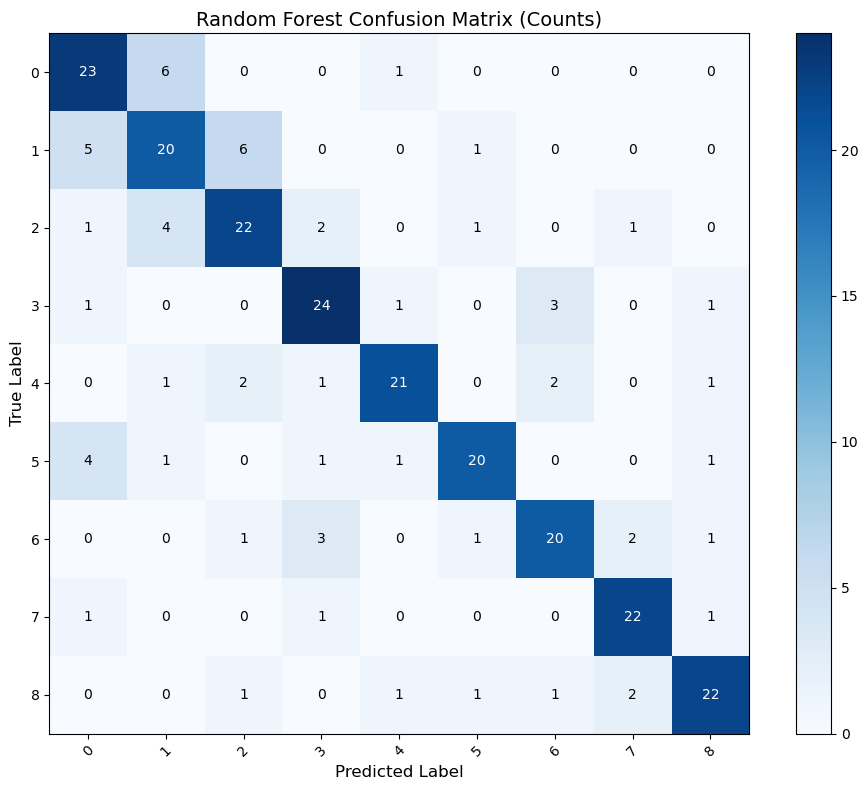

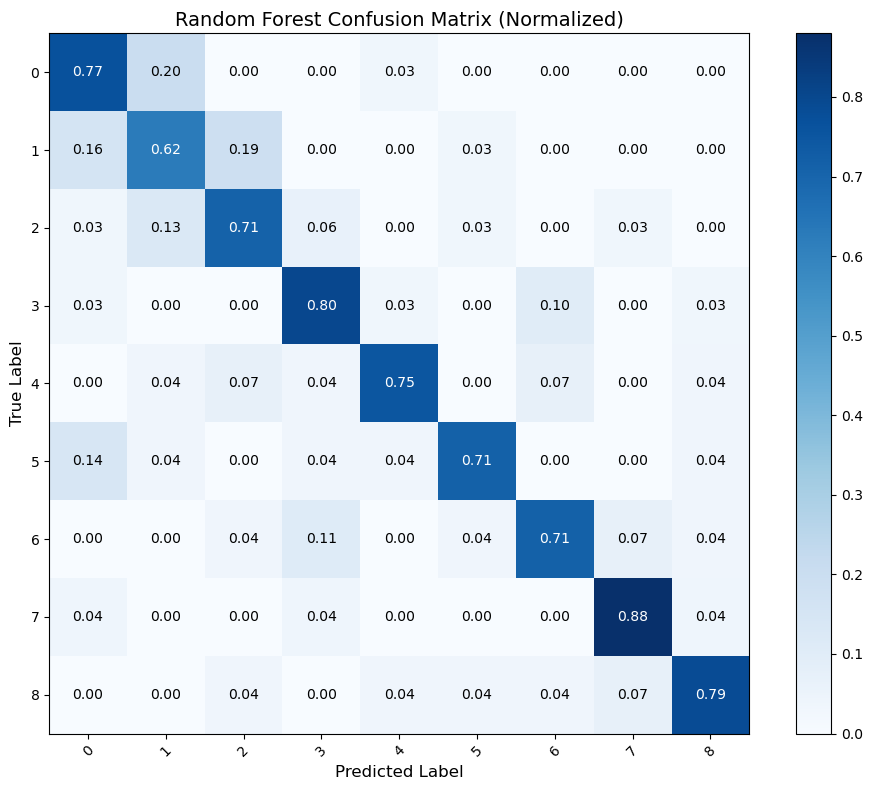

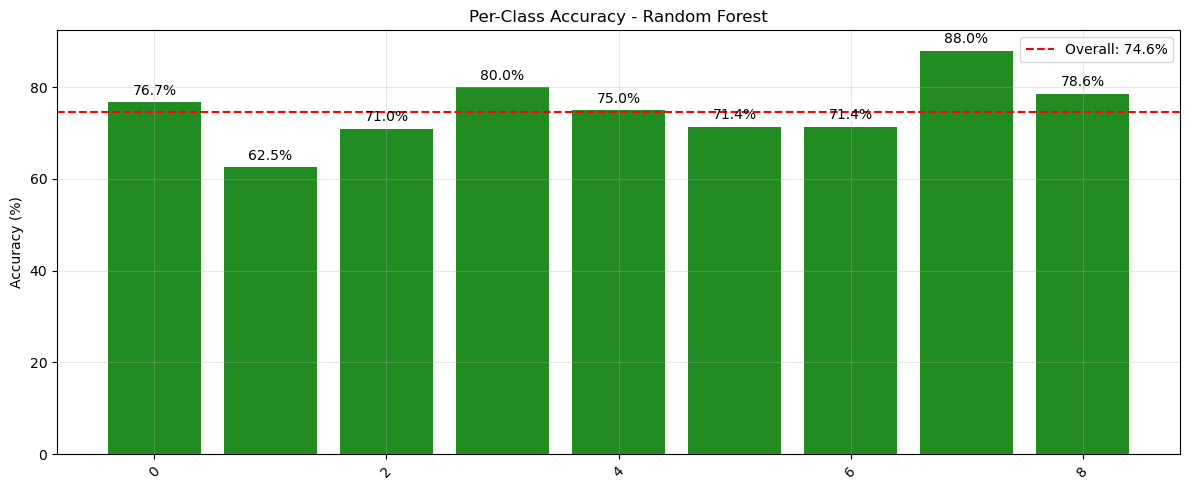

In [40]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, filename=None):
    """Plot and save confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(RESULTS_DIR, filename), dpi=150, bbox_inches='tight')
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, le.classes_, title='Random Forest Confusion Matrix (Counts)', 
                      filename='confusion_matrix_counts.png')
plot_confusion_matrix(cm, le.classes_, title='Random Forest Confusion Matrix (Normalized)', 
                      normalize=True, filename='confusion_matrix_normalized.png')

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
bars = plt.bar(le.classes_, class_accuracy * 100, color='forestgreen')
plt.axhline(y=accuracy*100, color='red', linestyle='--', label=f'Overall: {accuracy*100:.1f}%')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy - Random Forest')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

for bar, acc in zip(bars, class_accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc*100:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'per_class_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()

# Save per-class accuracy as CSV
per_class_df = pd.DataFrame({
    'class': le.classes_,
    'accuracy': class_accuracy
})
per_class_df.to_csv(os.path.join(RESULTS_DIR, 'per_class_accuracy.csv'), index=False)

## 8. Feature Importance Analysis

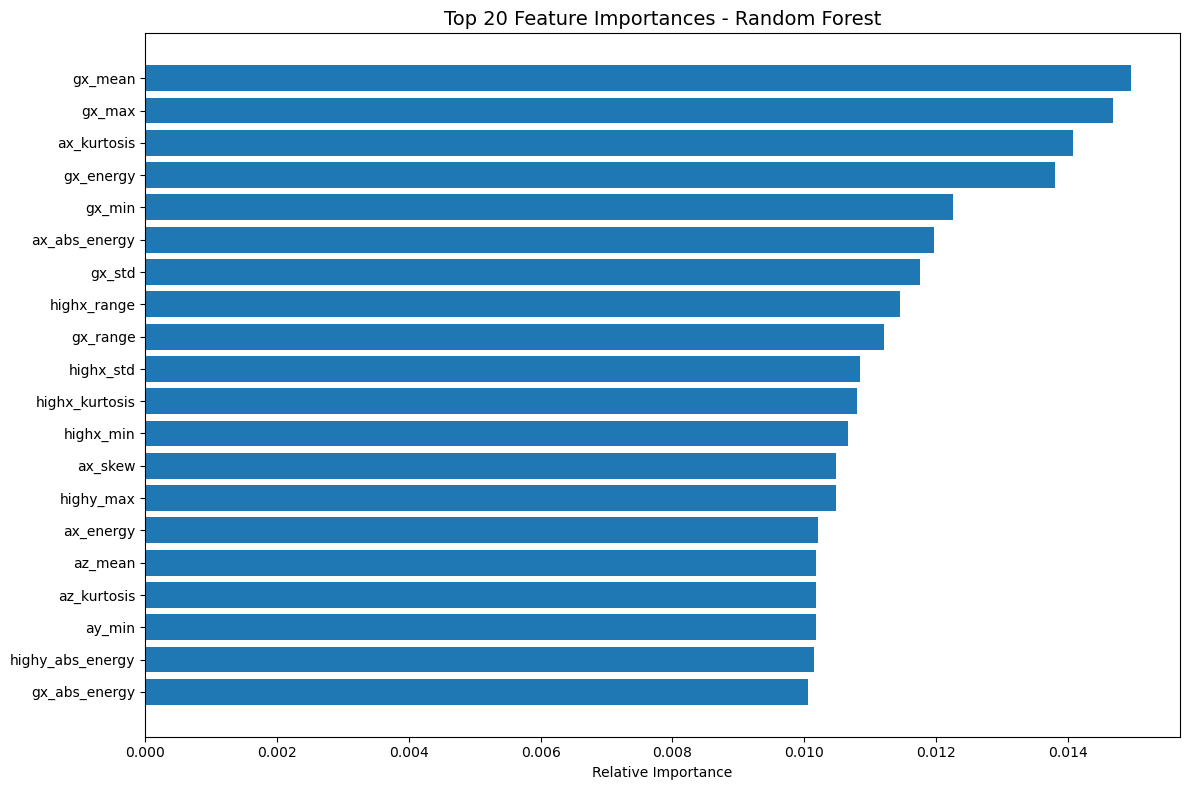


📊 Top 5 most important features:
    feature  importance
    gx_mean    0.014954
     gx_max    0.014684
ax_kurtosis    0.014080
  gx_energy    0.013812
     gx_min    0.012260


In [42]:
# Get feature importances from the Random Forest
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 20 features
plt.figure(figsize=(12, 8))
plt.title("Top 20 Feature Importances - Random Forest", fontsize=14)
plt.barh(range(20), importances[indices[:20]][::-1], align='center')
plt.yticks(range(20), [feature_names[i] for i in indices[:20]][::-1])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'top20_feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

# Save full feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
feature_importance_df.to_csv(os.path.join(RESULTS_DIR, 'feature_importances.csv'), index=False)

print("\n📊 Top 5 most important features:")
print(feature_importance_df.head(5).to_string(index=False))

## 9. Save results for later comparison

In [44]:
def save_rf_results(model, y_pred, y_test, accuracy, grid_search, le, exec_time):
    """Save Random Forest results in a unified format."""
    
    results = {
        'model_name': 'Random Forest',
        'dataset': 'Statistical Features',
        'accuracy': accuracy,
        'predictions': y_pred,
        'true_labels': y_test,
        'label_encoder': le,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'execution_time': exec_time,
        'feature_importances': model.feature_importances_,
        'feature_names': X_train.columns.tolist(),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Save as pickle
    with open(os.path.join(RESULTS_DIR, 'random_forest_results.pkl'), 'wb') as f:
        pickle.dump(results, f)
    
    # Save summary CSV
    summary_df = pd.DataFrame([{
        'Model': 'Random Forest',
        'Dataset': 'Statistical Features',
        'Accuracy': f'{accuracy*100:.2f}%',
        'CV Score': f'{grid_search.best_score_*100:.2f}%',
        'Time (s)': f'{exec_time:.1f}',
        'Training Samples': len(X_train),
        'Test Samples': len(X_test),
        'Features': X_train.shape[1],
        'Best Params': str(grid_search.best_params_)
    }])
    summary_df.to_csv(os.path.join(RESULTS_DIR, 'summary.csv'), index=False)
    
    print("\n💾 Results saved to:")
    print(f"   {RESULTS_DIR}/")
    print("   - random_forest_results.pkl")
    print("   - summary.csv")
    print("   - confusion_matrix_*.png")
    print("   - per_class_accuracy.png/.csv")
    print("   - feature_importances.csv")
    print("   - top20_feature_importance.png")
    print("   - classification_report.txt")

# Calculate total execution time (grid search + baseline training)
total_exec_time = grid_time + train_time

save_rf_results(best_rf, y_pred, y_test, accuracy, grid_search, le, total_exec_time)


💾 Results saved to:
   C:\Users\jumia\Downloads\BackTap\results\05_random_forest/
   - random_forest_results.pkl
   - summary.csv
   - confusion_matrix_*.png
   - per_class_accuracy.png/.csv
   - feature_importances.csv
   - top20_feature_importance.png
   - classification_report.txt


## 10. Final Summary and Comparison with DTW + KNN

In [46]:
# Load DTW+KNN results from the centralized directory (if available)
dtw_results_path = 'results/04_dtw_knn/dtw_knn_results.pkl'
dtw_accuracy = None
if os.path.exists(dtw_results_path):
    with open(dtw_results_path, 'rb') as f:
        dtw_data = pickle.load(f)
    dtw_accuracy = dtw_data['accuracy']
    print(f"📂 Loaded DTW+KNN results: {dtw_accuracy*100:.2f}%")
else:
    print("⚠️ DTW+KNN results not found. Set dtw_accuracy manually or skip comparison.")
    dtw_accuracy = 0.7192  # From user's reported result

print("\n" + "="*70)
print("🎯 RANDOM FOREST BENCHMARK COMPLETE")
print("="*70)

print(f"\n📊 Model Comparison:")
print(f"   • DTW + KNN (Notebook 4): {dtw_accuracy*100:.2f}%")
print(f"   • Random Forest (Baseline): {accuracy_baseline*100:.2f}%")
print(f"   • Random Forest (Optimized): {accuracy*100:.2f}%")

if accuracy > dtw_accuracy:
    print(f"\n   ✅ Random Forest outperforms DTW+KNN by {(accuracy - dtw_accuracy)*100:.2f}%")
else:
    print(f"\n   ⚠️ Random Forest underperforms DTW+KNN by {(dtw_accuracy - accuracy)*100:.2f}%")

print(f"\n📁 All outputs saved to: {RESULTS_DIR}/")

print("\n" + "="*70)
print("✅ Ready for Notebook 6: 1D CNN Implementation")
print("="*70)

⚠️ DTW+KNN results not found. Set dtw_accuracy manually or skip comparison.

🎯 RANDOM FOREST BENCHMARK COMPLETE

📊 Model Comparison:
   • DTW + KNN (Notebook 4): 71.92%
   • Random Forest (Baseline): 73.85%
   • Random Forest (Optimized): 74.62%

   ✅ Random Forest outperforms DTW+KNN by 2.70%

📁 All outputs saved to: C:\Users\jumia\Downloads\BackTap\results\05_random_forest/

✅ Ready for Notebook 6: 1D CNN Implementation
